# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM data

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'LMPP', 'NK progenitor', 'CD56 bright NK', 'mature NK', 
                                             'ILC precursor', 'NK T cell'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD56 bright NK    449
HSC                92
ILC precursor      67
LMPP               34
NK T cell         111
NK progenitor      26
mature NK         136
dtype: int64

# Change the colours for the celltype categories

In [9]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CD56 bright NK', 'HSC', 'ILC precursor', 'LMPP', 'NK T cell', 'NK progenitor', 'mature NK'], dtype='object')

In [10]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'LMPP', 'NK progenitor', 
                        'CD56 bright NK', 'mature NK', 'ILC precursor', 'NK T cell'])

In [11]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'LMPP', 'NK progenitor', 'CD56 bright NK', 'mature NK', 'ILC precursor', 'NK T cell'], dtype='object')

In [12]:
adata.obs["cell.labels"].cat.categories[2]

'NK progenitor'

In [13]:
new_colors = np.empty(len(adata.obs["cell.labels"].cat.categories), dtype=object) 

new_colors[[0]] = '#1B6633' # HSC
new_colors[[1]] = '#D1DB94' # LMPP
new_colors[[2]] = '#F9F06C' # NK progenitor
new_colors[[3]] = '#F59771' # CD56 bright NK
new_colors[[4]] = '#b63262' # mature NK
new_colors[[5]] = '#4C79BC' # ILC precursor
new_colors[[6]] = '#A9479A' # NK T cell

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#1B6633', '#D1DB94', '#F9F06C', '#F59771', '#b63262', '#4C79BC',
       '#A9479A'], dtype=object)

# Pre-process the data

In [14]:
# normalise count data 
sc.pp.normalize_total(adata)

In [15]:
# log the count data 
sc.pp.log1p(adata)

In [16]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [17]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [18]:
# run pca
sc.tl.pca(adata, n_comps=50)

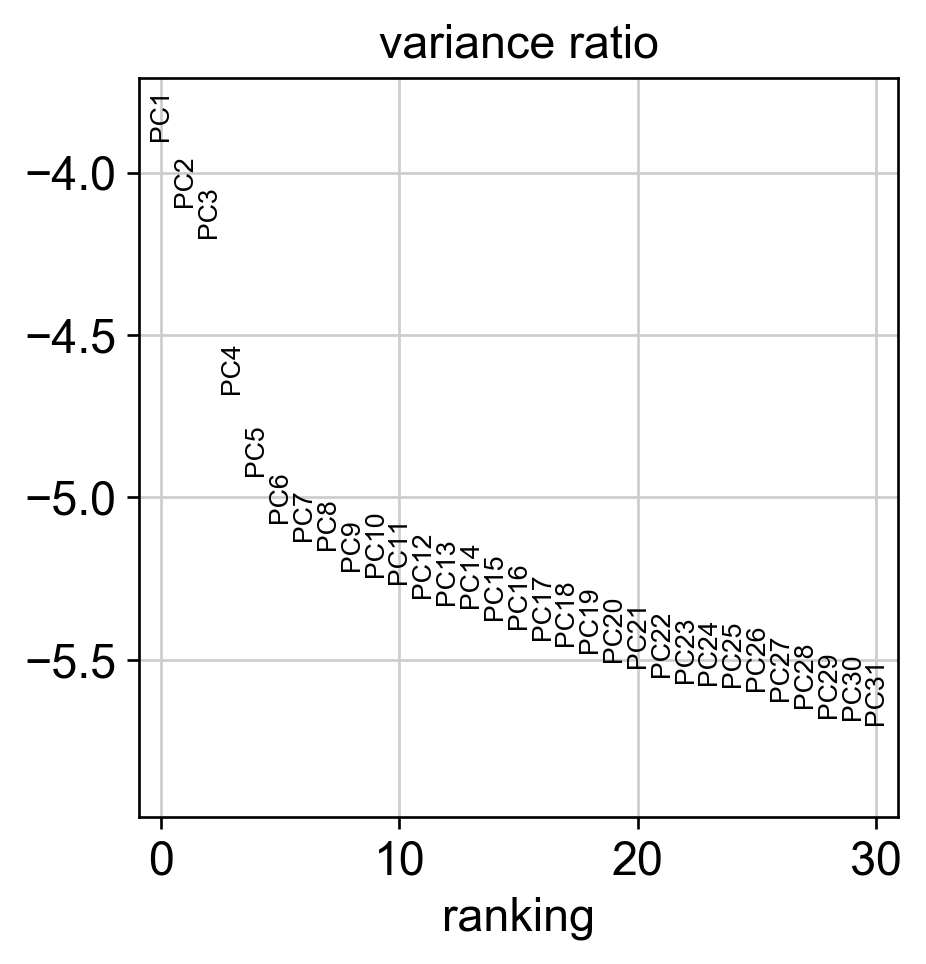

In [19]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [21]:
# run umap
sc.tl.umap(adata) 

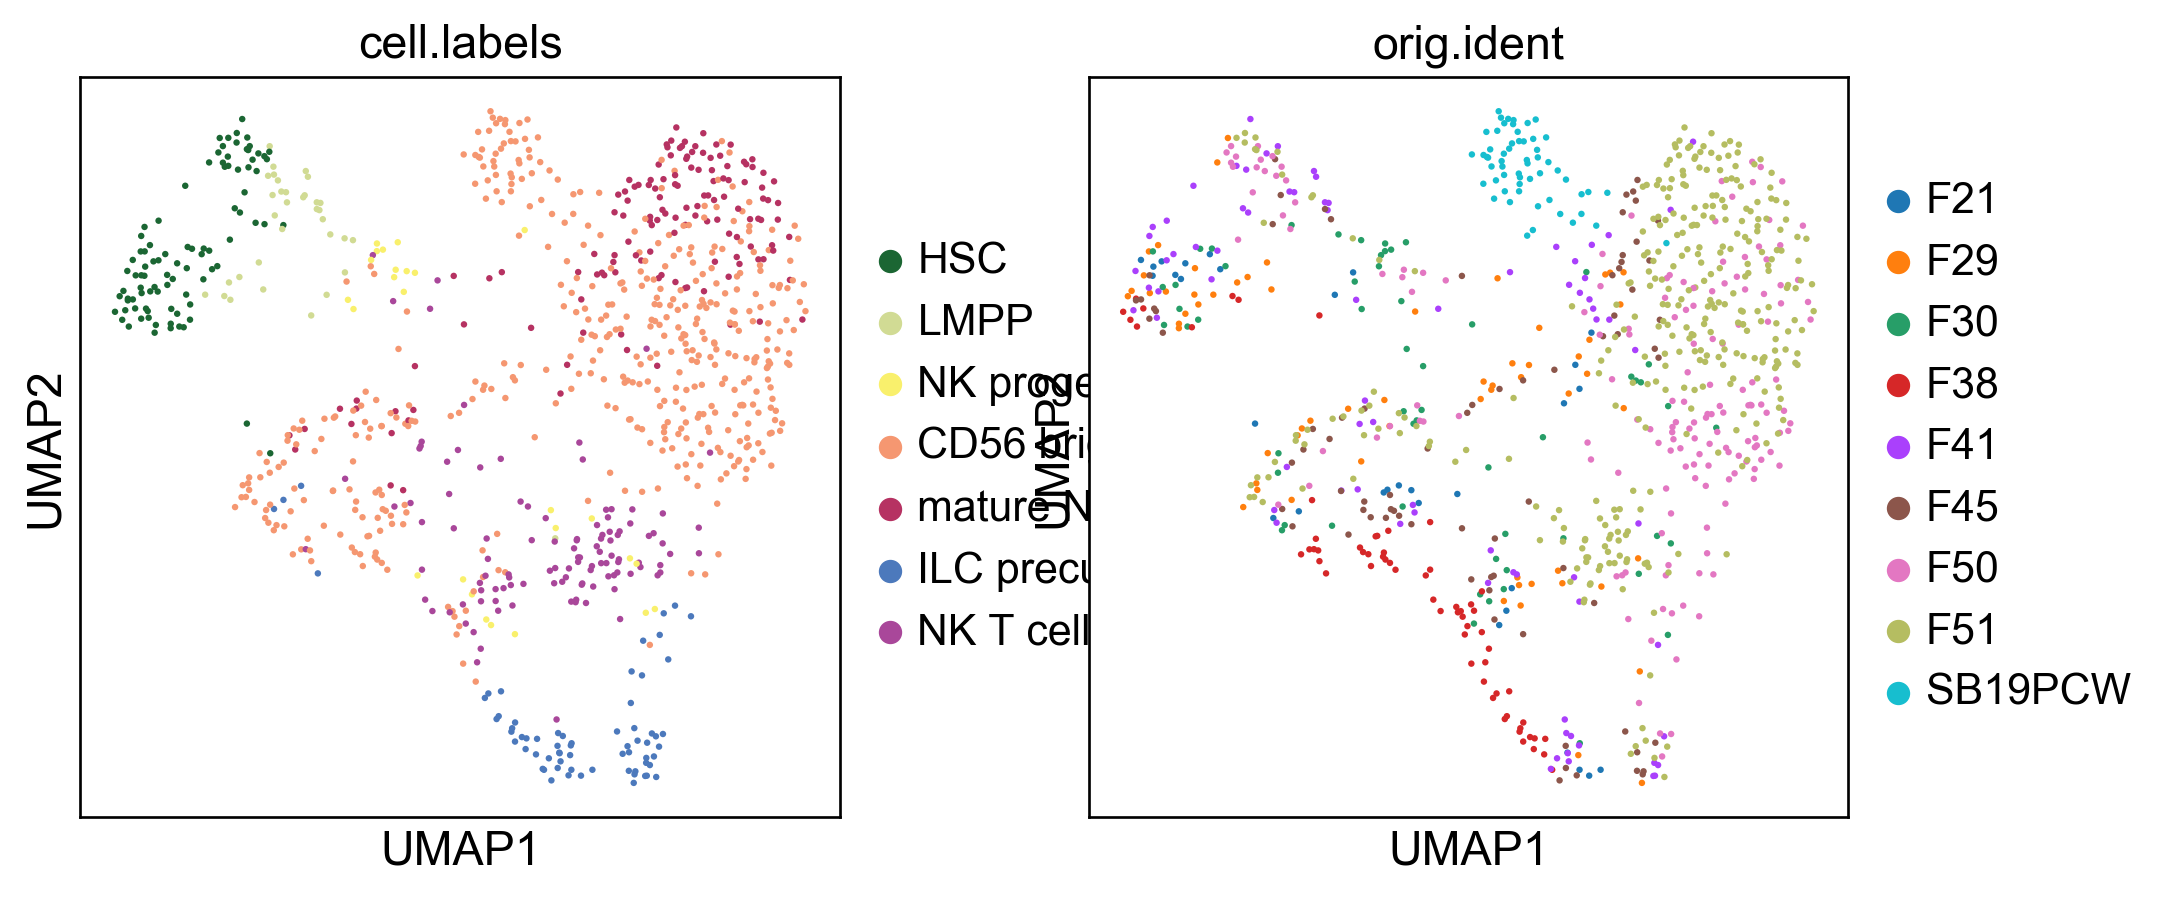

In [22]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [23]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [24]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [25]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [26]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add UMAP and FDG

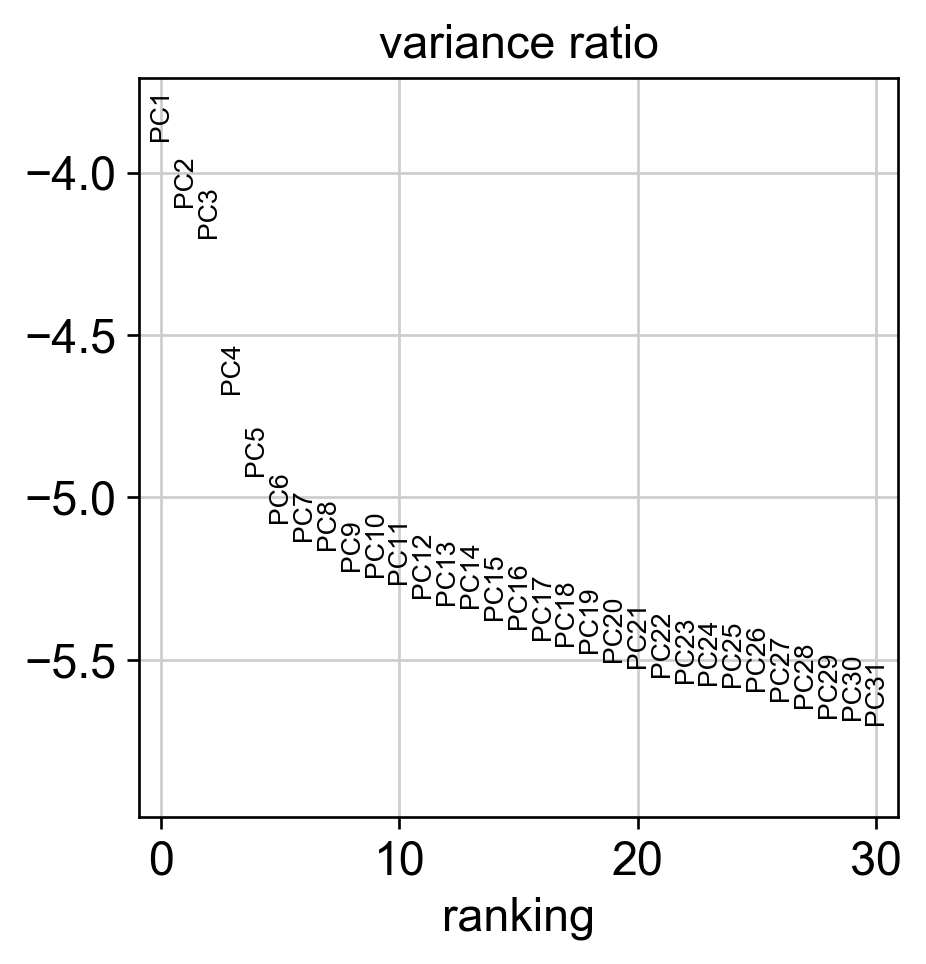

In [27]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=5) 

In [29]:
# run umap
sc.tl.umap(adata) 

In [30]:
# run fdg 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

# Plot UMAP and FDG by celltype

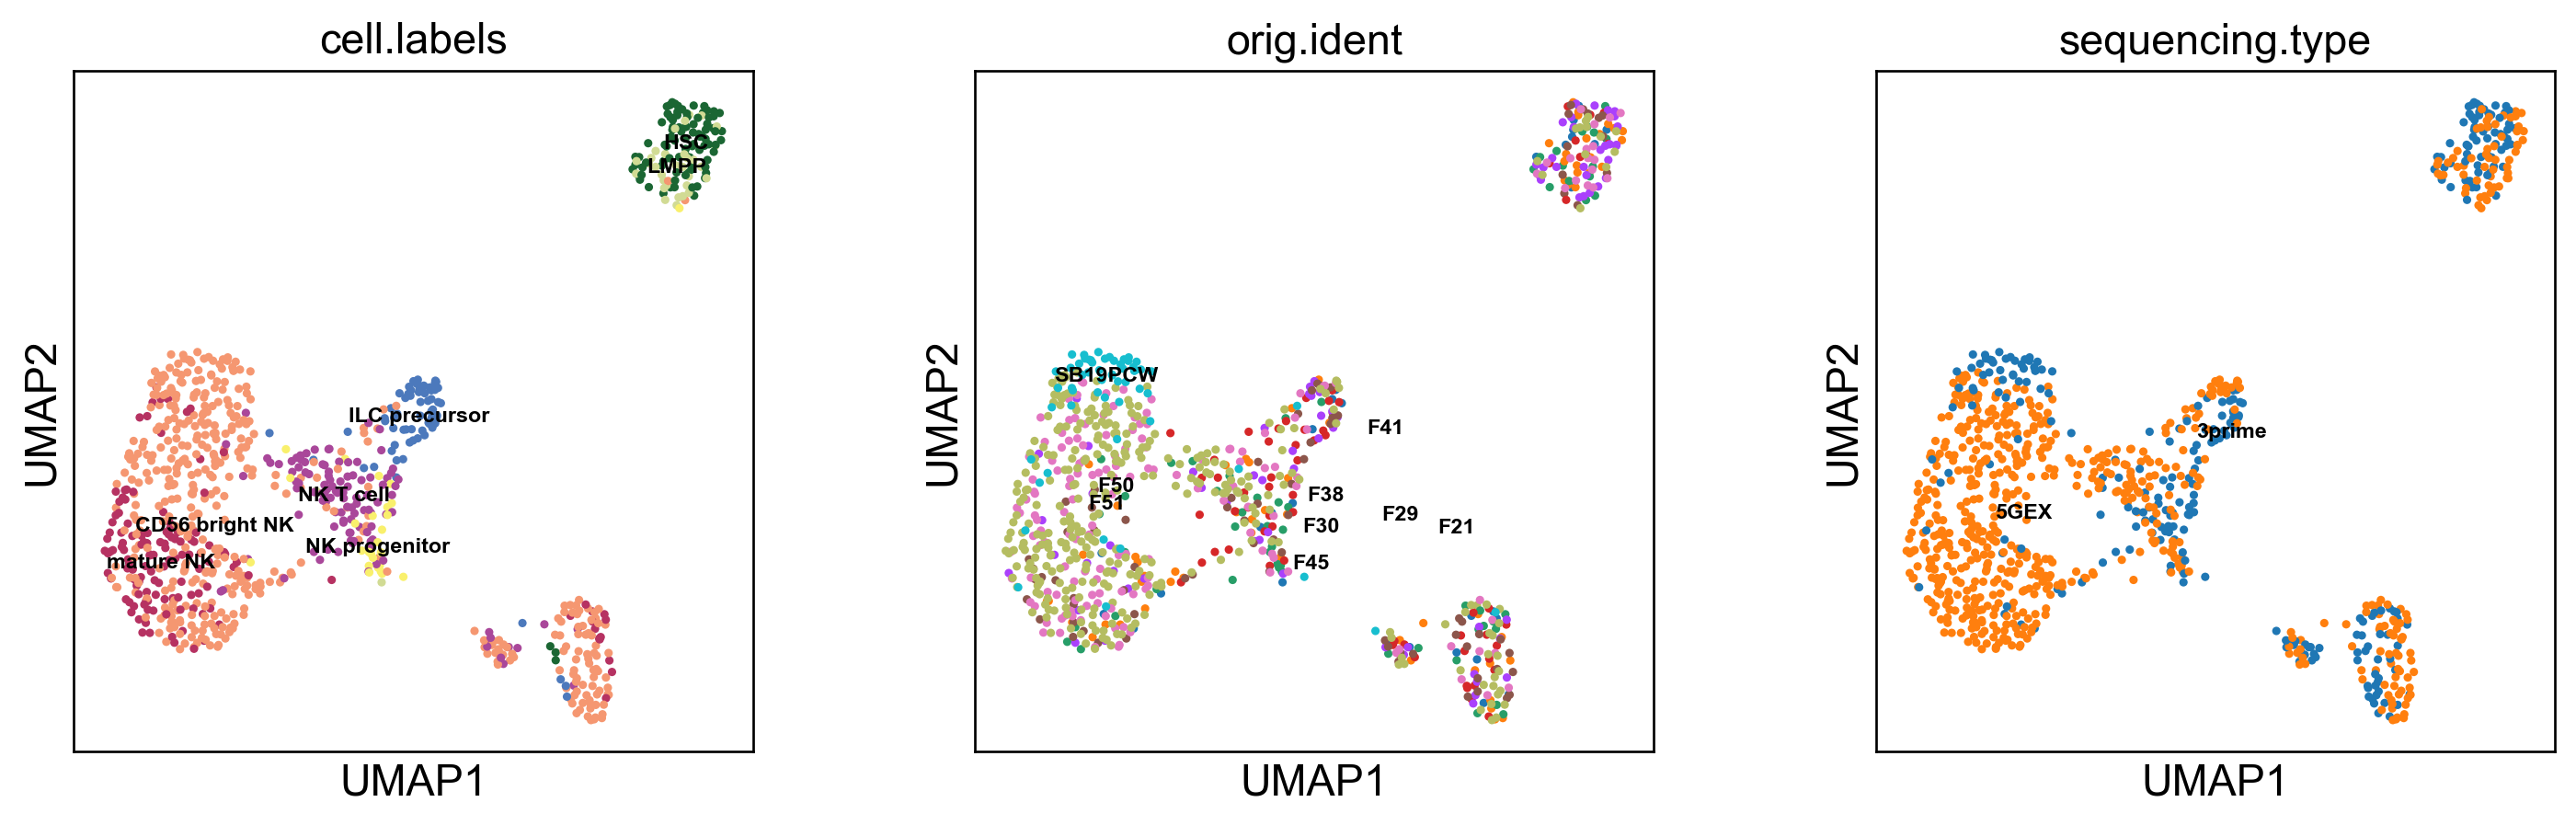

In [31]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident', 'sequencing.type'], size=30, legend_loc="on data", 
           legend_fontsize=7) 

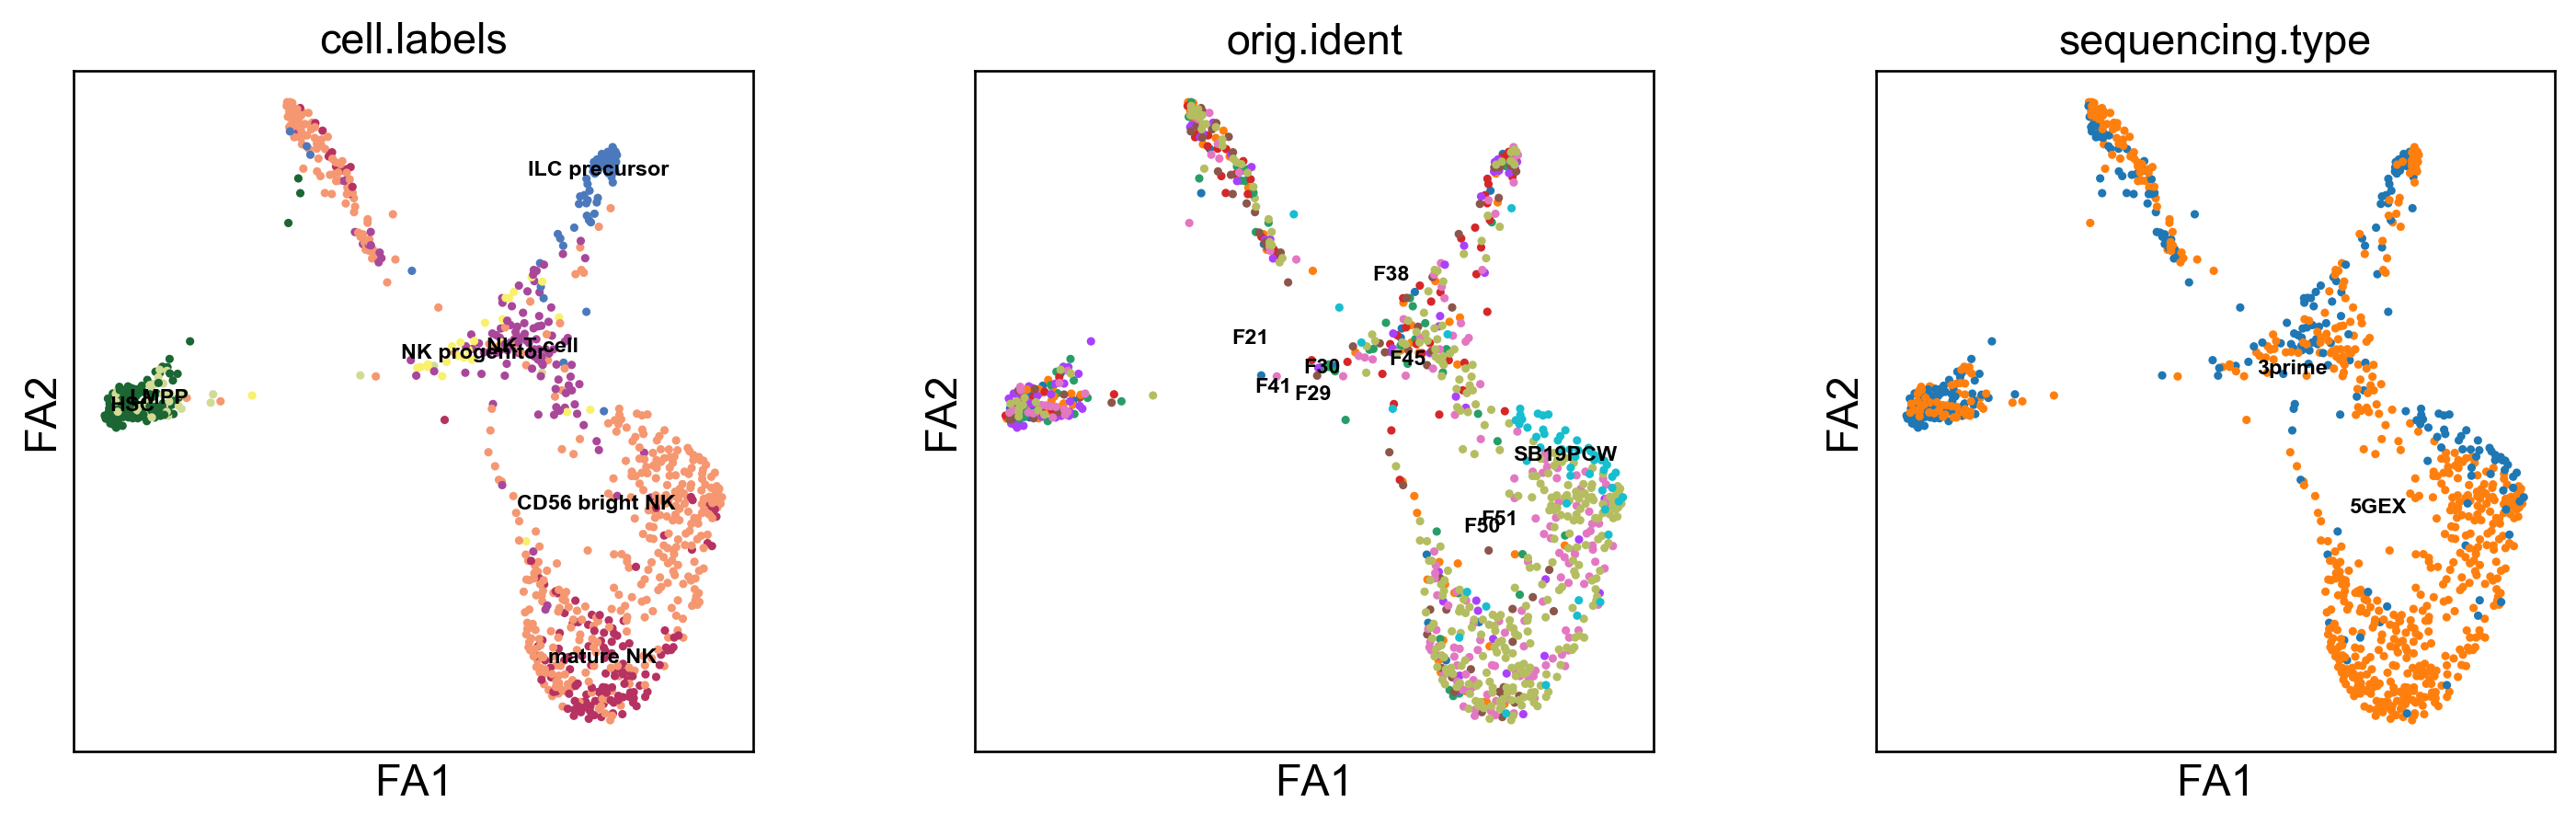

In [32]:
sc.pl.draw_graph(adata, color=['cell.labels', 'orig.ident', 'sequencing.type'], layout='fa', legend_loc="on data", 
           legend_fontsize=7, size=30)

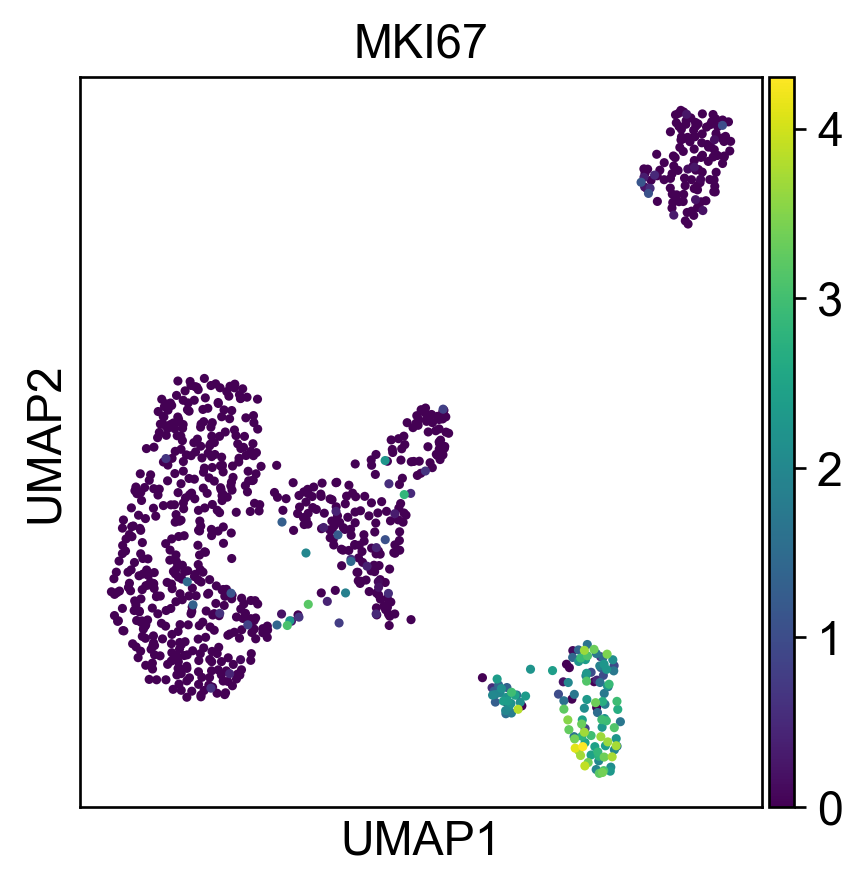

In [33]:
sc.pl.umap(adata, color=["MKI67"], size=30, legend_loc="on data", 
           legend_fontsize=7, use_raw=False) 

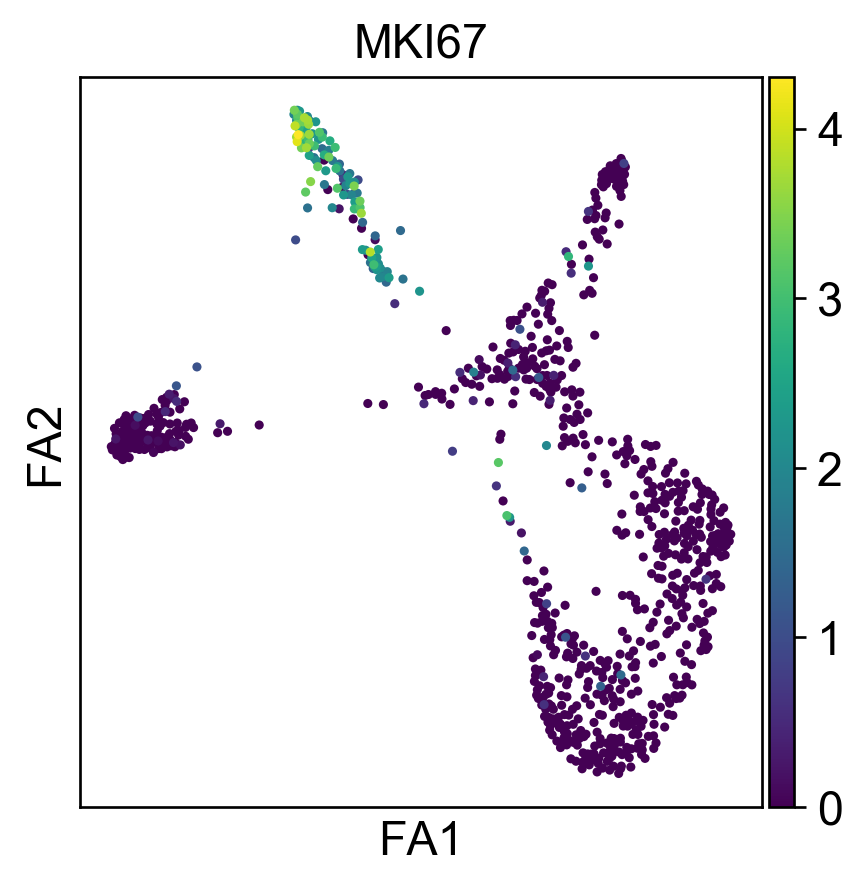

In [34]:
sc.pl.draw_graph(adata, color=['MKI67'], layout='fa', legend_loc="on data", 
           legend_fontsize=7, size=30, use_raw=False)

# Save plots

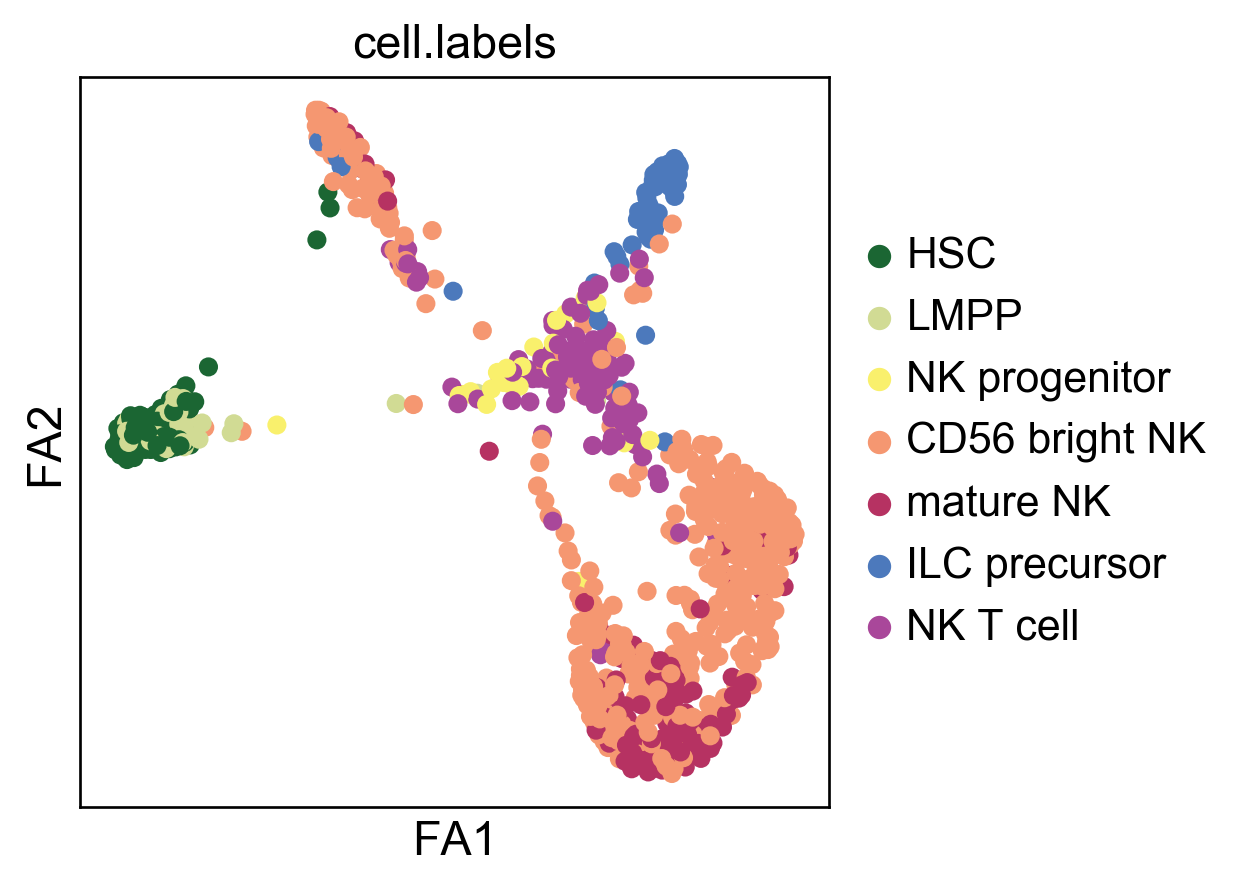

In [35]:
sc.pl.draw_graph(adata, color=['cell.labels'], layout='fa', save="fig2f_nk_ilc_fdg_20210111.pdf")

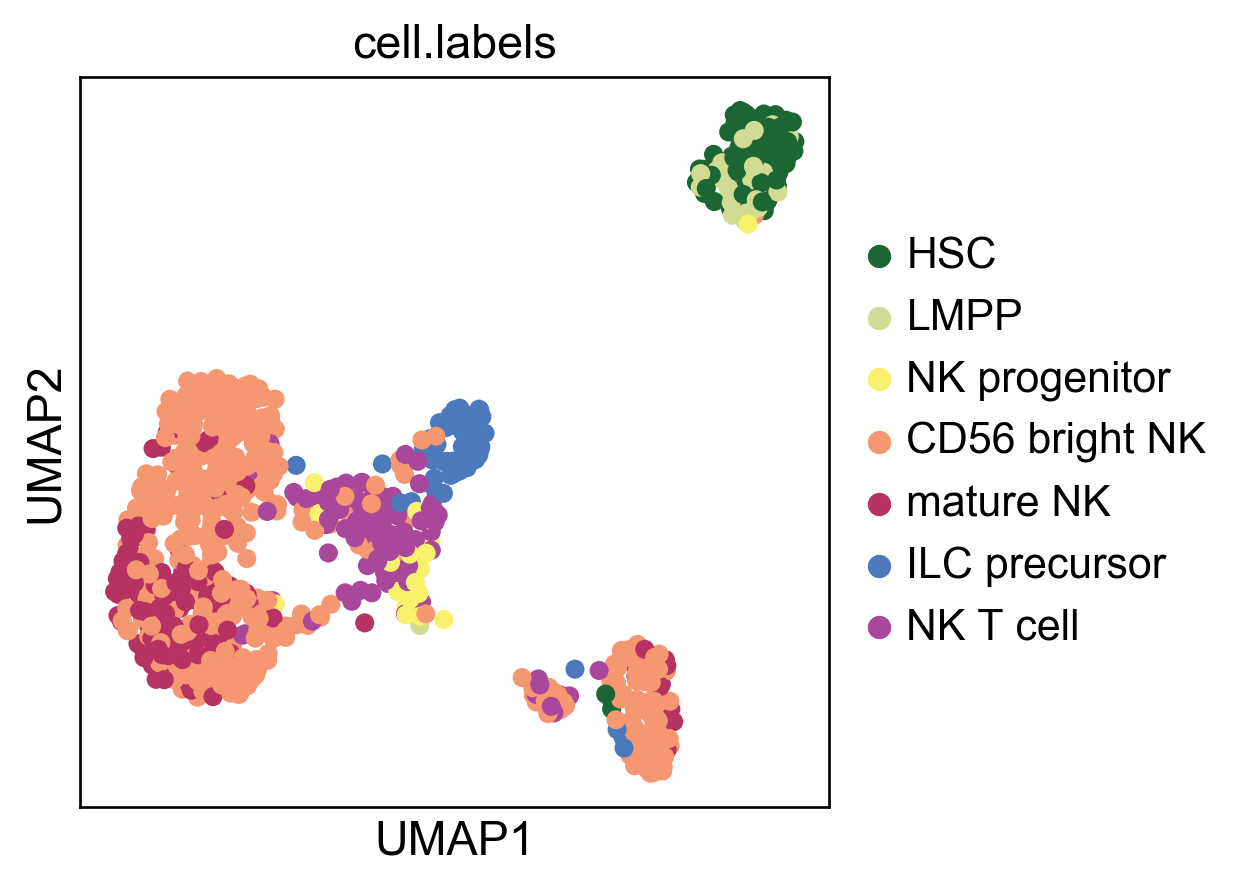

In [36]:
sc.pl.umap(adata, color=['cell.labels'], save="fig2f_nk_ilc_umap_20210111.pdf")

# Save the data

In [37]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [38]:
adata.X

<915x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 1775223 stored elements in Compressed Sparse Row format>

In [39]:
adata.raw.X

<915x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 1946116 stored elements in Compressed Sparse Row format>

In [40]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig2f_nk_ilc_dr_20210111.h5ad")